# Лабораторная работа №2
## Калинников Сергей 15-АС
### Вариант 8 (зоопарк)
### Цель работы: получение навыков работы с методами классификации.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
from scipy import interp
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (auc, roc_curve, 
                             precision_recall_curve, 
                             average_precision_score)

from sklearn import datasets
from sklearn.linear_model import perceptron
from sklearn.preprocessing import LabelEncoder
from sklearn import neighbors
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
from matplotlib.pylab import rc, plot

df = pd.read_csv(r'zoo.csv', sep=',')

### 1.	Изучить набор данных. Создать описание набора данных на русском языке. Описать признаки, используемые в наборе данных (включить полученные описания в отчёт).

#### Этот набор данных состоит из 101 животного из зоопарка. 16 показателей с различными чертами для описания животных. Существует 7 типов: млекопитающие, птицы, рептилии, рыбы, амфибии, жуки и беспозвоночные.


| Атрибут   | Описание  | Значения  | 
|-----------|-----------|-----------|
|animal_name|Имя животного|Уникальное|
|hair|Волосы| Boolean|
|feathers|Перья| Boolean|
|eggs|Яйца| Boolean|
|milk|Молоко| Boolean|
|airborne|Воздушный| Boolean|
|aquatic|Водный| Boolean|
|predator|Хищник| Boolean|
|toothed|Зубастый| Boolean|
|backbone|Позвоночный| Boolean|
|breathes|Дышащий| Boolean|
|venomous|Ядовитый| Boolean|
|fins|Плавники| Boolean|
|legs|Количество ног| Числовое{0,2,4,5,6,8}|
|tail|Хвостатые| Boolean|
|domestic|Домашние| Boolean|
|catsize|Размером с кота| Boolean|
|class_type|Тип класса| Числовой[1,7]|

In [2]:
df.head()

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


### 2.	Удалите дубликаты строк в наборе данных; приведите размер набора данных до и после данной операции

In [3]:
df.shape

(101, 18)

In [4]:
df = df.drop_duplicates()
df = df.dropna()
df.drop(['animal_name'], axis=1, inplace=True)
df.shape

(101, 17)

### 3.	Оцените сбалансированность данных по классам (постройте гистограмму). Используйте полученную информацию при выборе метрики оценки качества классификации (PR или ROC кривая).

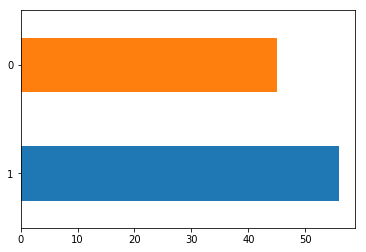

In [5]:
df['predator'].value_counts().plot(kind='barh')
plt.show()

Соотношение количество элементов несколько отличается, поэтому будем считать, что классы несбалансированны. Будем использовать ROC-кривую

### 4.	Выполните масштабирование количественных признаков; Постройте диаграммы BoxPlot для признаков до и после масштабирования. Выберите способ масштабирования (например, нормализацию или стандартизацию)

In [6]:
numerical_columns = [i for i in df.columns if df[i].dtype.name != 'object']
categorial_columns = [i for i in df.columns if df[i].dtype.name == 'object']

print('numerical: ', numerical_columns)
print('categorial: ', categorial_columns)

numerical:  ['hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'predator', 'toothed', 'backbone', 'breathes', 'venomous', 'fins', 'legs', 'tail', 'domestic', 'catsize', 'class_type']
categorial:  []


In [7]:
df['class_type'] = df['class_type'].apply(lambda x: str(x))

#заново выделим категориальные и числовые
numerical_columns = [i for i in df.columns if df[i].dtype.name != 'object']
categorial_columns = [i for i in df.columns if df[i].dtype.name == 'object']

print('numerical: ', numerical_columns)
print('categorial: ', categorial_columns)

numerical:  ['hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'predator', 'toothed', 'backbone', 'breathes', 'venomous', 'fins', 'legs', 'tail', 'domestic', 'catsize']
categorial:  ['class_type']


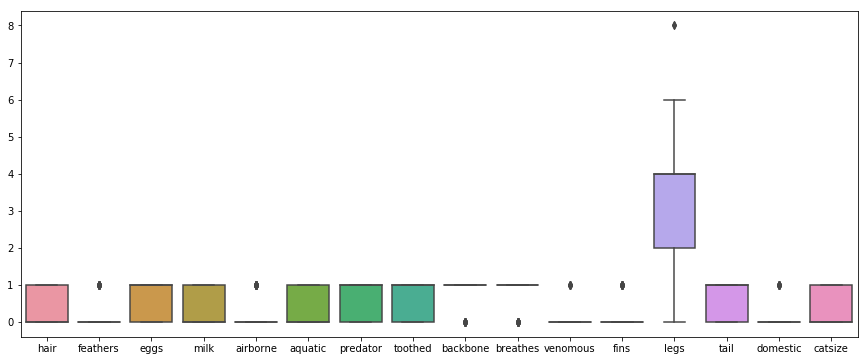

In [8]:
plt.figure(figsize=(15,6))
sns.boxplot(data=df[numerical_columns])
plt.show()

В качестве способа масштабирования выберем метод нормализации, т.к. устраняет шум перед использованием классификатора.

In [9]:
scaler = MinMaxScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
df.head()

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.5,0.0,0.0,1.0,1
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.5,1.0,0.0,1.0,1
2,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,4
3,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.5,0.0,0.0,1.0,1
4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.5,1.0,0.0,1.0,1


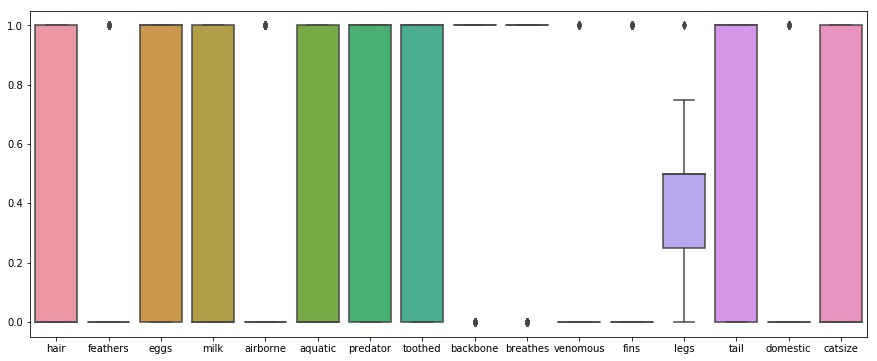

In [10]:
plt.figure(figsize=(15,6))
sns.boxplot(data=df[numerical_columns])
plt.show()

### 5.	Выполните замену категориальных признаков.

In [11]:
for i in categorial_columns:
    print(i,': ', df[i].unique())

class_type :  ['1' '4' '2' '7' '6' '5' '3']


In [12]:
# выделим бинарные и небинарные признаки
binary_columns = [i for i in categorial_columns if len(df[i].unique()) == 2]
nonbinary_columns = [i for i in categorial_columns if len(df[i].unique()) > 2]
    
# для бинарных заменим значения на 1 и 0
for col in binary_columns:
    for i, unic_item in enumerate(df[col].unique()):
        df[col] = df[col].replace(to_replace=[unic_item], value=[i])
        
# для не бинарых применим dummy-кодирование
df_nonbinary = pd.get_dummies(df[nonbinary_columns])
df.drop(nonbinary_columns, axis=1, inplace=True)
df = pd.concat([df_nonbinary, df] , axis=1)

print(df.shape)
df.head()

(101, 23)


,class_type_1,class_type_2,class_type_3,class_type_4,class_type_5,class_type_6,class_type_7,hair,feathers,eggs,...,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize
0,1,0,0,0,0,0,0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.5,0.0,0.0,1.0
1,1,0,0,0,0,0,0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.5,1.0,0.0,1.0
2,0,0,0,1,0,0,0,0.0,0.0,1.0,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1,0,0,0,0,0,0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.5,0.0,0.0,1.0
4,1,0,0,0,0,0,0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.5,1.0,0.0,1.0


### 6.	Оцените корреляцию между признаков и удалите те признаки, которые коррелируют с наибольшим числом других (удалять признаки нужно только для линейных методов классификации).

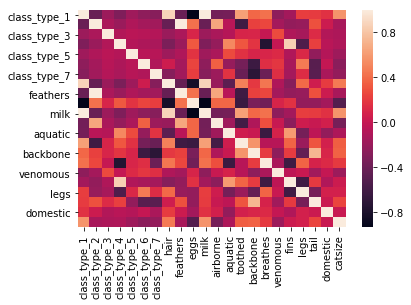

In [13]:
df_corr = df.drop('predator', axis=1).corr()
sns.heatmap(df_corr)
plt.show()

In [15]:
df_corr

,class_type_1,class_type_2,class_type_3,class_type_4,class_type_5,class_type_6,class_type_7,hair,feathers,eggs,...,aquatic,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize
class_type_1,1.000000,-0.410761,-0.188654,-0.317722,-0.167865,-0.242449,-0.274028,0.878503,-0.410761,-0.938848,...,-0.362613,0.628168,0.384958,0.423527,-0.242449,-0.156328,0.214196,0.210026,0.163928,0.574906
class_type_2,-0.410761,1.000000,-0.113402,-0.190987,-0.100906,-0.145739,-0.164722,-0.427851,1.000000,0.419248,...,-0.058552,-0.613631,0.231403,0.254588,-0.145739,-0.223541,-0.206686,0.292569,0.031586,-0.135934
class_type_3,-0.188654,-0.113402,1.000000,-0.087716,-0.046344,-0.066935,-0.075653,-0.196503,-0.113402,0.099944,...,-0.074542,0.091479,0.106279,0.004454,0.271087,-0.102668,-0.140045,0.134371,-0.087716,-0.108458
class_type_4,-0.317722,-0.190987,-0.087716,1.000000,-0.078050,-0.112729,-0.127412,-0.330941,-0.190987,0.324287,...,0.516459,0.311240,0.178989,-0.750180,-0.003252,0.854369,-0.539799,0.226301,-0.059441,-0.099182
class_type_5,-0.167865,-0.100906,-0.046344,-0.078050,1.000000,-0.059559,-0.067317,-0.174849,-0.100906,0.171334,...,0.272866,0.164441,0.094567,0.104042,0.128424,-0.091354,0.116265,-0.228781,-0.078050,-0.178416
class_type_6,-0.242449,-0.145739,-0.066935,-0.112729,-0.059559,1.000000,-0.097226,0.044047,-0.145739,0.247458,...,-0.218272,-0.362192,-0.629805,0.150269,0.185484,-0.131944,0.457840,-0.498135,-0.003252,-0.257687
class_type_7,-0.274028,-0.164722,-0.075653,-0.127412,-0.067317,-0.097226,1.000000,-0.285430,-0.164722,0.212432,...,0.168580,-0.409368,-0.711840,-0.401958,0.148270,-0.149130,0.140643,-0.487199,-0.127412,-0.224396
hair,0.878503,-0.427851,-0.196503,-0.330941,-0.174849,0.044047,-0.285430,1.000000,-0.427851,-0.817382,...,-0.473554,0.492531,0.191681,0.441149,-0.104245,-0.280313,0.394009,0.048973,0.207208,0.455020
feathers,-0.410761,1.000000,-0.113402,-0.190987,-0.100906,-0.145739,-0.164722,-0.427851,1.000000,0.419248,...,-0.058552,-0.613631,0.231403,0.254588,-0.145739,-0.223541,-0.206686,0.292569,0.031586,-0.135934
eggs,-0.938848,0.419248,0.099944,0.324287,0.171334,0.247458,0.212432,-0.817382,0.419248,1.000000,...,0.376244,-0.642150,-0.340420,-0.382777,0.098689,0.164796,-0.224918,-0.221090,-0.155610,-0.514650


In [17]:
del df['eggs']
df.head()

,class_type_1,class_type_2,class_type_3,class_type_4,class_type_5,class_type_6,class_type_7,hair,feathers,milk,...,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize
0,1,0,0,0,0,0,0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.5,0.0,0.0,1.0
1,1,0,0,0,0,0,0,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.5,1.0,0.0,1.0
2,0,0,0,1,0,0,0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1,0,0,0,0,0,0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.5,0.0,0.0,1.0
4,1,0,0,0,0,0,0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.5,1.0,0.0,1.0


### 7.	Заполните пропущенные значения в данных.

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 0 to 100
Data columns (total 22 columns):
class_type_1    101 non-null uint8
class_type_2    101 non-null uint8
class_type_3    101 non-null uint8
class_type_4    101 non-null uint8
class_type_5    101 non-null uint8
class_type_6    101 non-null uint8
class_type_7    101 non-null uint8
hair            101 non-null float64
feathers        101 non-null float64
milk            101 non-null float64
airborne        101 non-null float64
aquatic         101 non-null float64
predator        101 non-null float64
toothed         101 non-null float64
backbone        101 non-null float64
breathes        101 non-null float64
venomous        101 non-null float64
fins            101 non-null float64
legs            101 non-null float64
tail            101 non-null float64
domestic        101 non-null float64
catsize         101 non-null float64
dtypes: float64(15), uint8(7)
memory usage: 13.3 KB


### 8.	Решите поставленную задачу классификации в соответствии с заданием. При подборе параметров классификатора используйте метод GridSearchCV и перекрёстную проверку (изучите возможные для изменения параметры классификации). Определите схему построения многоклассового классификатора, используемую по умолчанию (опишите используемую схему кодирования, обоснуйте свой выбор). Постройте, если это возможно, многоклассовую классификацию на основе схем «один-против-всех» и «все-против-всех». Оцените точность классификации для каждой их схем. Постройте кривые PR и ROC (для каждого из классов должны быть построены отдельные кривые, а также кривые для микро и макроусреднения метрик качества). Для линейного классификатора используйте регуляризацию.

Классификатор K ближайших соседей (задаётся радиус для выбора ближайших объектов);
Линейный классификатор (персептрон).

In [19]:
# разделим полученные данные на данные для обучения и теста
X, y = df.drop('predator', axis=1), df['predator']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

print(X_train.shape)
print(X_test.shape)

(70, 21)
(31, 21)


### K ближайших соседей (радиус)

In [20]:
rnc = RadiusNeighborsClassifier(outlier_label=1)

params = {'radius': np.arange(0, 5, 0.25)}

rnc_grid = GridSearchCV(rnc, params)
rnc_grid.fit(X_train, y_train)

best_radius = rnc_grid.best_estimator_.radius
best_score = rnc_grid.best_score_
print('best train score:', best_score, '\t at radius:', best_radius)

rnc = RadiusNeighborsClassifier(outlier_label=1, radius=best_radius)
rnc.fit(X_train, y_train)
best_score  = np.mean(y_test  == rnc.predict(X_test))
print('test score: ', best_score)

best train score: 0.7 	 at radius: 2.5
test score:  0.6451612903225806


### Линейный классификатор (персептрон)

In [25]:
slf = sk.linear_model.Perceptron()
paramsearch = GridSearchCV(estimator=slf, param_grid=dict(alpha=np.linspace(0,2,20)[1:],n_iter=[int(50)]), n_jobs=int(10))
paramsearch.fit(X_train, y_train)
best_score = paramsearch.best_score_
selected_alpha = paramsearch.best_estimator_.alpha
print('best score=',best_score,'at alpha',selected_alpha)
best_n_iter = paramsearch.best_estimator_.n_iter
best_n_jobs = paramsearch.best_estimator_.n_jobs

dtc = sk.linear_model.Perceptron(alpha=selected_alpha,n_iter=best_n_iter,n_jobs=best_n_jobs)
dtc.fit(X_train, y_train)
test_score  = np.mean(y_test == dtc.predict(X_test))
print('test score: ', test_score)

best score= 0.6285714285714286 at alpha 0.10526315789473684
test score:  0.7419354838709677


In [22]:
class CustomClassifier(RadiusNeighborsClassifier):
        
    def predict_proba(self, X_test, X_train, y_train):
        '''
        Общее описание.
         Определяет вероятность того, что тестовый экземпляр соответствует классу.
        
         Алгоритм.
         Мы пройдем нулевой радиус до радиуса двойного классификатора
         с элементарным шагом (dr). Если экземпляр находится вдоль:
         * Zero raduis + dr - соответствует 100%
         * Классификатор raduis + dr - соответствует 50%
         * Двойной классификатор raduis + dr и за его пределами - соответствует 0%
         Имеются промежуточные значения процентов. Каждый шаг соответствует своему
         собственному процентному(от всей величины) значению. Если предсказанный экземпляр меняет
         класс, этот экземпляр принадлежит текущему радиусу.
        
        '''
        runs = 25
        dr = (2*self.radius/runs)
        
        radiuses = [dr*i for i in range(runs)]  
        percentage = [i/runs for i in range(runs)]
        percentage = sorted(percentage, reverse=True)
        probas = np.ndarray((len(y_test),2), dtype=np.float)
        for i in range(len(probas)):
            probas[i] = [0, 1]
        
        for i, radius in enumerate(radiuses):
            if i==0:
                rnc_temp = RadiusNeighborsClassifier(radius, outlier_label=1)
                predict_first = rnc_temp.fit(X_train, y_train).predict(X_test)
                continue
            else:
                predict_second = predict_first
                rnc_tmp = RadiusNeighborsClassifier(radius, outlier_label=1)
                predict_first = rnc_tmp.fit(X_train, y_train).predict(X_test)
        
            for j, (p1, p2) in enumerate(zip(predict_first, predict_second)):
                if p1!=p2:
                    probas[j,0] = percentage[i]
                    probas[j,1] = 1-probas[j,0]
                
        return probas

Для построения ROC и PR кривых необходимо получить вероятности принадлежности примера к одному из классов, а затем варьировать границу выбора класса. Вероятности можно получить с помощью метода predict_proba

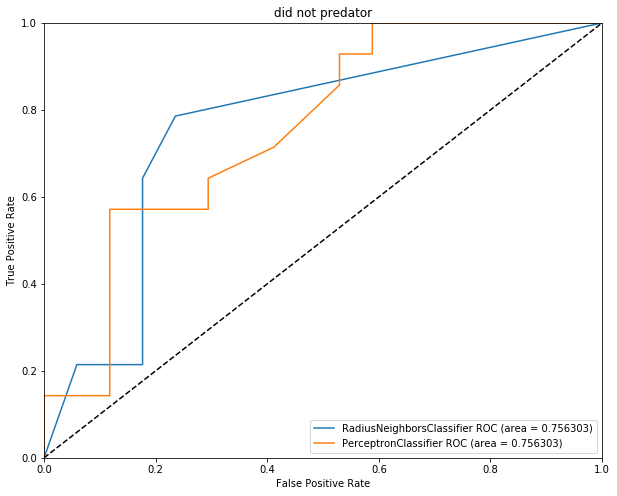

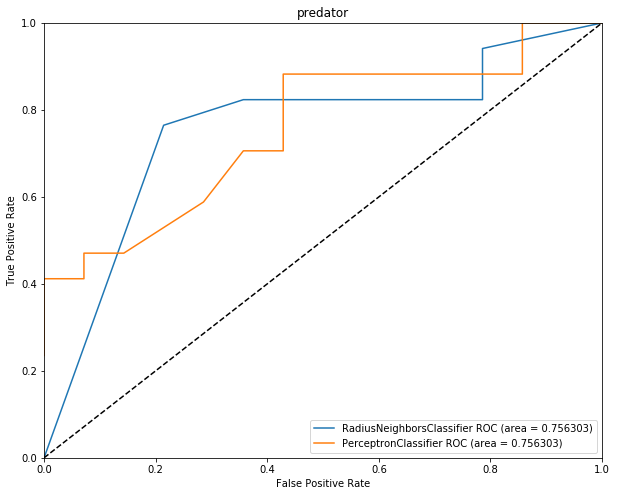

In [23]:
clf_isotonic = CalibratedClassifierCV(slf, cv=10, method='isotonic')
clf_isotonic.fit(X_train, y_train)
probas_slf0 = clf_isotonic.predict_proba(X_test)
clf_isotonic.fit(X_train, y_train)
probas_slf1 = clf_isotonic.predict_proba(X_test)

#ROC графики
plt.figure(figsize=(10,8))
# K соседей
mrnc = CustomClassifier(outlier_label=1, radius=best_radius)
probas_mrnc0 = mrnc.predict_proba(X_test, X_train, y_train)
tpr, fpr, thresholds = roc_curve(y_test, probas_mrnc0[:,0])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('RadiusNeighborsClassifier', roc_auc))
# Персептрон
tpr, fpr, thresholds = roc_curve(y_test, probas_slf0[:,0])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('PerceptronClassifier', roc_auc))
# вывод графика
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4, fontsize='medium')
plt.title('did not predator')
plt.show()

plt.figure(figsize=(10,8))
# K соседей
probas_mrnc1 = mrnc.predict_proba(X_test, X_train, y_train)
fpr, tpr, thresholds = roc_curve(y_test, probas_mrnc1[:,1])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('RadiusNeighborsClassifier', roc_auc))
# Персептрон
fpr, tpr, thresholds = roc_curve(y_test, probas_slf1[:,1])
roc_auc  = auc(fpr, tpr)
plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('PerceptronClassifier', roc_auc))   

# вывод графика
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4, fontsize='medium')
plt.title('predator')
plt.show()

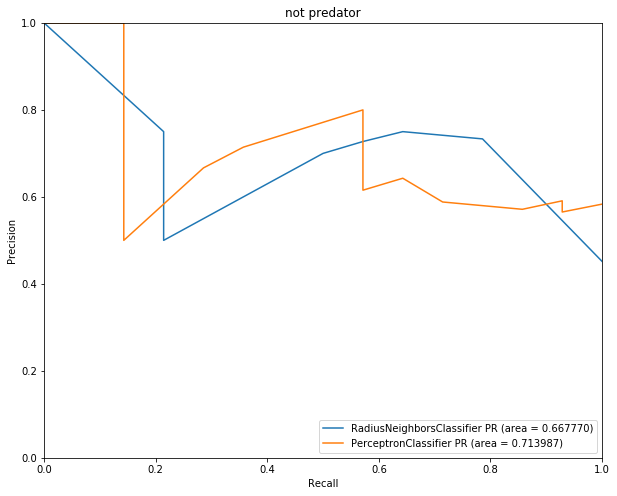

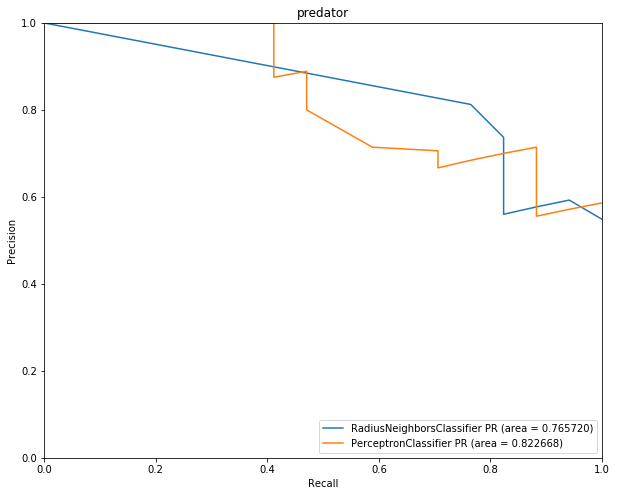

In [24]:
#PR графики
plt.figure(figsize=(10,8))
y_test_invers = []
for i, y in enumerate(y_test.reset_index(drop=True)):
    y_test_invers.append(1-y)
# K соседей
probas_mrnc1 = mrnc.predict_proba(X_test, X_train, y_train)
precision, recall, thresholds = precision_recall_curve(y_test_invers, probas_mrnc1[:,0])
aps_mrnc1 = average_precision_score(y_test_invers,probas_mrnc1[:,0])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('RadiusNeighborsClassifier', aps_mrnc1))
# Персептрон
precision, recall, thresholds = precision_recall_curve(y_test_invers, probas_slf1[:,0])
aps_slf1 = average_precision_score(y_test_invers,probas_slf1[:,0])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('PerceptronClassifier',  aps_slf1))
# вывод графика
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc=4, fontsize='medium')
plt.title('not predator')
plt.show()

plt.figure(figsize=(10,8))
# K соседей
precision, recall, thresholds = precision_recall_curve(y_test, probas_mrnc1[:,1])
aps_mrnc1 = average_precision_score(y_test,probas_mrnc1[:,1])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('RadiusNeighborsClassifier', aps_mrnc1))
# Персептрон
precision, recall, thresholds = precision_recall_curve(y_test, probas_slf1[:,1])
aps_slf1 = average_precision_score(y_test,probas_slf1[:,1])
plt.plot(recall, precision, label='%s PR (area = %f)' % ('PerceptronClassifier',  aps_slf1)) 
# вывод графика
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc=4, fontsize='medium')
plt.title('predator')
plt.show()

### 9. Сравните кривые для классификаторов, указанных в задании, сделайте выводы.

Данные классификаторы решают задачу классификации с вероятностью 0.76~0.8, что является хорошим результатом, т.к. классов всего 2. Персептрон дает лучший результат, благодаря хорошо подобранным параметрам и многослойной сетке. Поэтому задача классификации была решена корректно